In [1]:
import pandas as pd
import seaborn as sns
from pylab import rcParams

%pylab inline
%config InlineBackend.figure_format = 'retina' 

Populating the interactive namespace from numpy and matplotlib


# Sociation.org
## Ежемесячная статистика слов, пользователей и ассоциаций

In [201]:
month_stat = pd.read_csv('sociation_month_stat.csv', parse_dates=['month'], index_col=['month'])
month_stat.tail()

,users,user_associations,associations,words
month,,,,
2017-06-01,154,8853,3179,107
2017-07-01,137,9744,3650,72
2017-08-01,125,9609,4498,209
2017-09-01,134,12268,5647,215
2017-10-01,74,5229,2308,100


### Динамика роста показателей с 2009 года

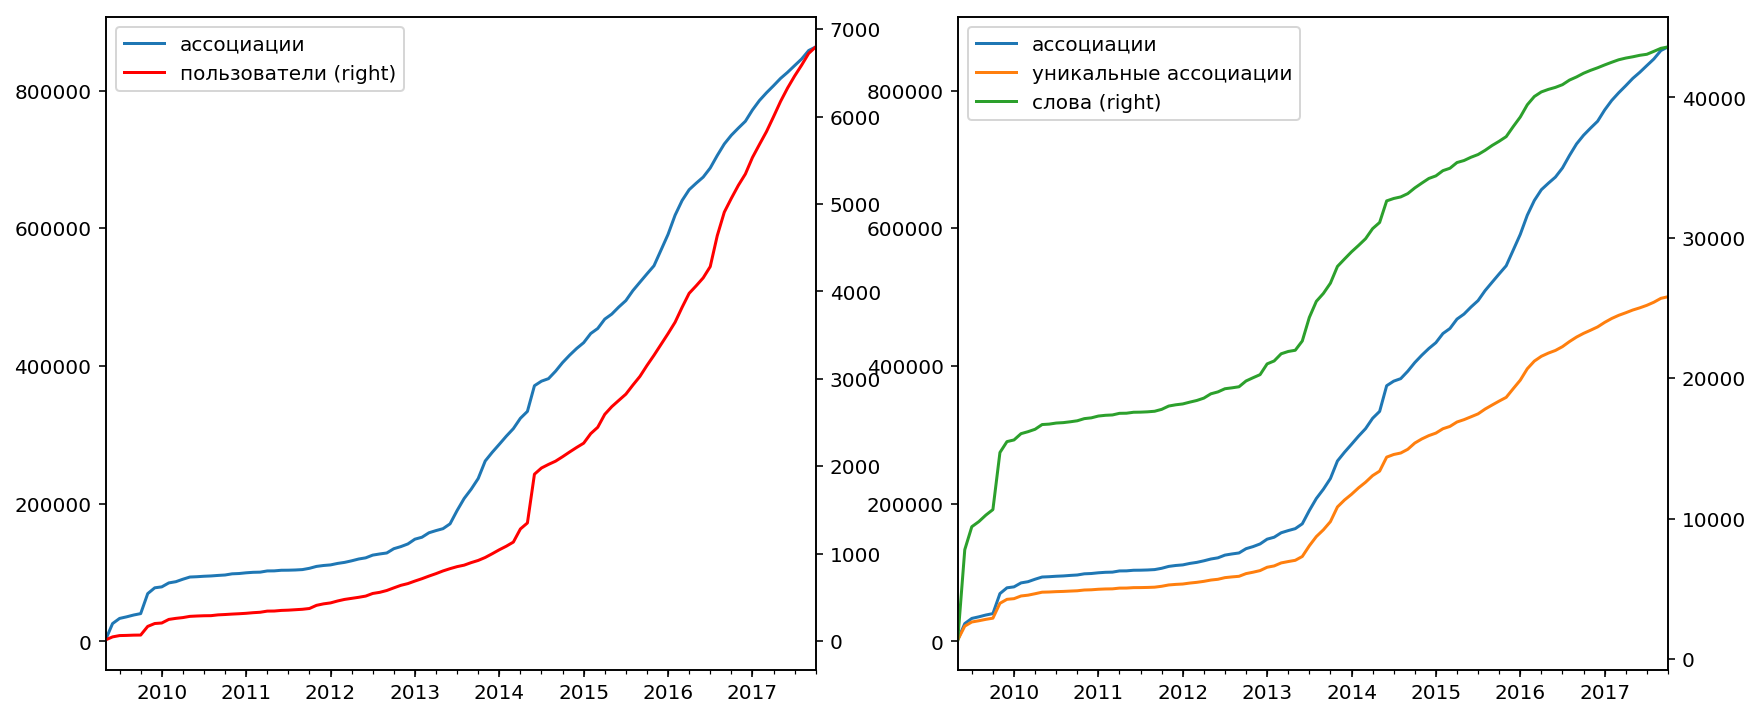

In [255]:
# Получаем из ежемесячной статистики накопительную
month_stat_sum = month_stat.cumsum()

# При выводе с двумя осями Y (secondary_y=True) какой-то баг с указанием легенды axes[0].legend()
# Оказалось проще переименовать колонки чем изменять легенду
month_stat_sum.columns = ['пользователи', 'ассоциации', 'уникальные ассоциации', 'слова']

rcParams['figure.figsize'] = 14,6
fig, axes = plt.subplots(nrows=1, ncols=2)
month_stat_sum[['ассоциации', 'пользователи']].plot(ax=axes[0], secondary_y=['пользователи'], color=[None, 'r'])
month_stat_sum[['ассоциации', 'уникальные ассоциации', 'слова']].plot(ax=axes[1], secondary_y=['слова'])
axes[0].set_xlabel('')
axes[1].set_xlabel('');

### Доля уникальных ассоциаций среди добавленных

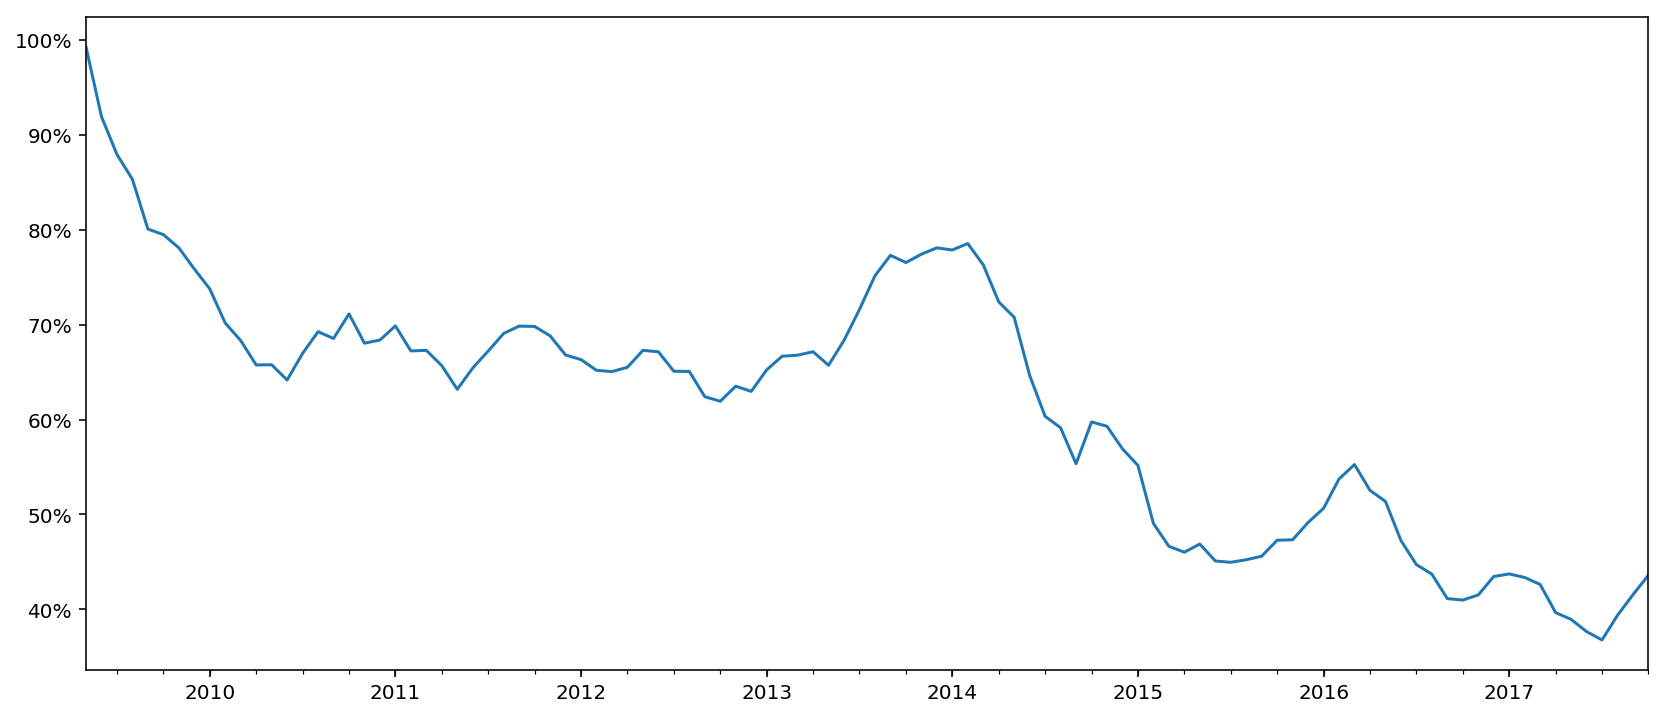

In [282]:
assoc_uniqueness = month_stat.associations / month_stat.user_associations
ax = assoc_uniqueness.rolling(4, min_periods=1).mean().plot()

# Показываем проценты вместо чисел 0..1
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_xlabel('');

### Выводы

- Примерно с 2014 года число зарегистрированных пользователей и добавленных ими ассоциаций линейно растёт. Старые уходят теряя интерес, новые приходят (иначе рост числа ассоциаций имел бы экспоненциальный характер).
- Несмотря на линейный рост ассоциаций пользователей (`user_associations`), рост числа новых слов и уникальных ассоциаций (`associations`) постепенно замедляется, что говорит о насыщении. Большинство общеупотребимых слов названы, более 50% добавленных ассоциаций за последний год уже кем-то назывались.

## Статистика по пользователям

In [175]:
users = pd.read_csv('sociation_users.csv')
users.tail()

,sex,fb,email_domain,associations,words,badwords,abuse
6796,M,0,yandex.ru,11221,409,243,2
6797,F,0,yandex.ru,16387,775,466,0
6798,M,1,gmail.com,45766,3540,882,13
6799,F,1,yandex.ru,47031,1808,2128,3
6800,M,1,yandex.ru,120455,6156,2024,6


### Число добавленных слов и ошибок в зависимости от почтового домена пользователя

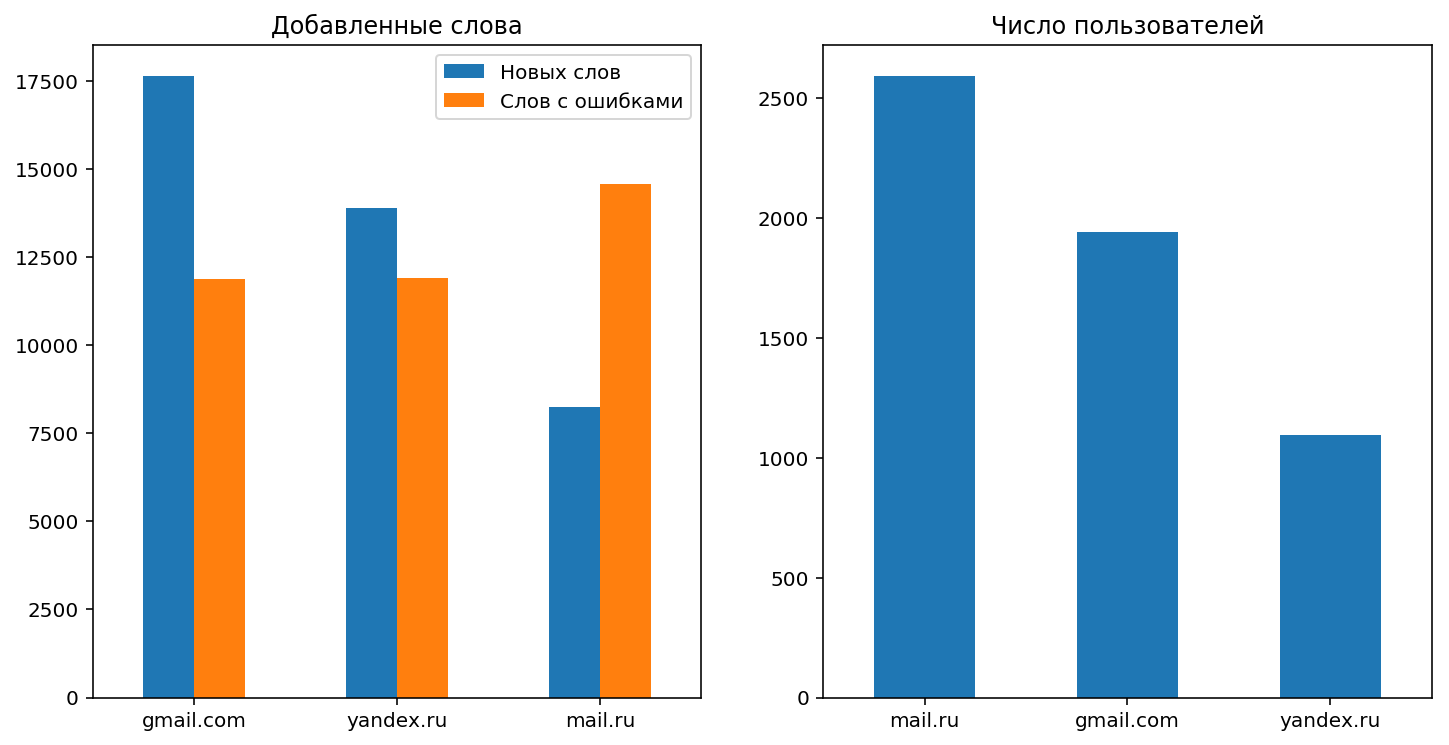

In [137]:
# Объединяем известные домены mail/yandex/hotmail
users.email_domain.replace({
    'inbox.ru': 'mail.ru',
    'bk.ru': 'mail.ru',
    'list.ru': 'mail.ru',
    'mail.ua': 'mail.ru',
    'yandex.com': 'yandex.ru',
    'ya.ru': 'yandex.ru',
    'yandex.ua': 'yandex.ru',
    'narod.ru': 'yandex.ru',
    'live.com': 'hotmail.com',
    'msn.com': 'hotmail.com',
    'live.ru': 'hotmail.com',
    'outlook.com': 'hotmail.com',
}, inplace=True)

# Число зарегистрированных пользователей с почтой на домене
users_count_by_mail = users.email_domain.value_counts()

# Сумарное число слов и ошибок по почтовому домену
users_by_mail = users.groupby('email_domain')
badwords_by_mail = users_by_mail[['words', 'badwords']].sum().sort_values('words', ascending=False)

rcParams['figure.figsize'] = 12,6
fig, axes = plt.subplots(nrows=1, ncols=2)
badwords_by_mail.head(3).plot(kind='bar', rot=0, ax=axes[0])
users_count_by_mail.head(3).plot(kind='bar', rot=0, ax=axes[1])

axes[0].set_title('Добавленные слова')
axes[0].legend(['Новых слов', 'Слов с ошибками'])
axes[0].set_xlabel('')
axes[1].set_title('Число пользователей');

### Выводы
Пользователи mail.ru самые безграмотные, обладают маленьким словарным запасом, зато их больше всех

### Пол ироков в ассоциации и употребление ненормативной лексики 

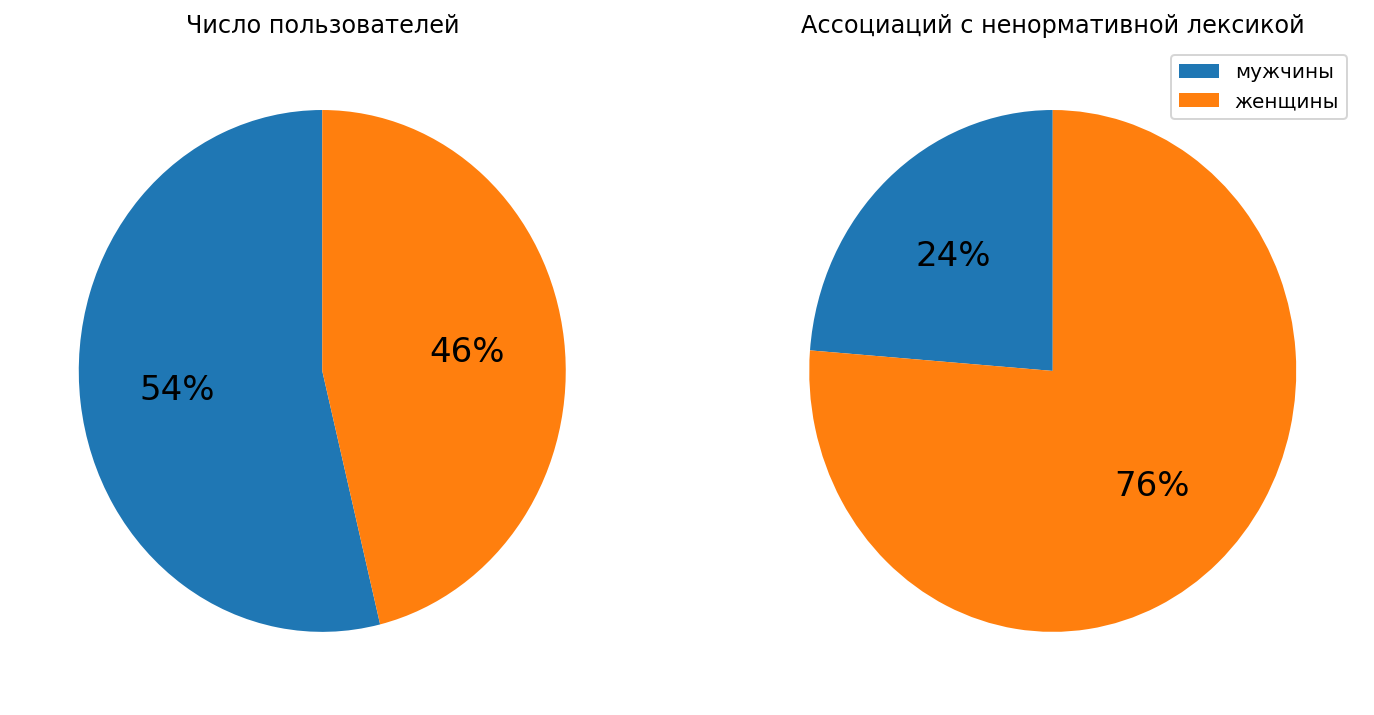

In [173]:
# Общее число пользователей по полу
users_count_by_sex = users.sex.value_counts()

# Число ассоциаций с ненормативной лексикой / общее число ассоциаций
# Сравниваем долю среди мужчин и женщин вместо абсолютных значений
users_by_sex = users.groupby('sex').sum()
abuse_by_sex = users_by_sex.abuse / users_by_sex.associations * 1000

rcParams['figure.figsize'] = 12,6
fig, axes = plt.subplots(nrows=1, ncols=2)
common_attrs = dict(kind='pie', autopct='%1.0f%%', startangle=90, fontsize=17, label='', labels=['', ''])
users_count_by_sex.plot(ax=axes[0],  title='Число пользователей', **common_attrs)
abuse_percent_by_sex.plot(ax=axes[1], title='Ассоциаций с ненормативной лексикой', **common_attrs)
axes[1].legend(['мужчины', 'женщины']);

### Выводы

- Вероятно у женщин больше свободного времени
- Мужчины матерятся

### Распределение числа добавленных ассоциаций в зависимости от пола

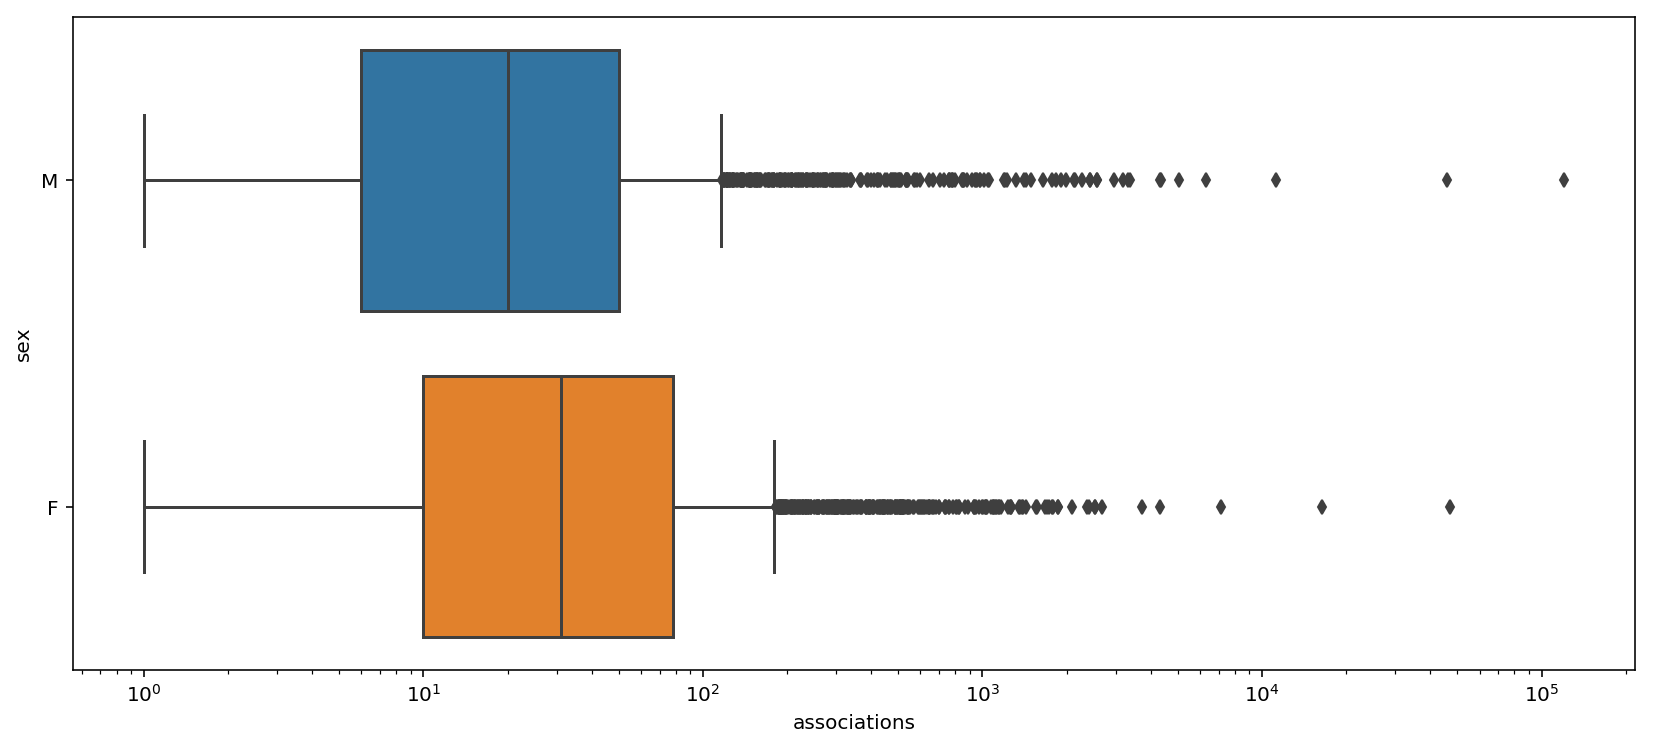

In [483]:
g=sns.boxplot(data=users, x='associations', y='sex')
g.set_xscale('log')

### Выводы

Несмотря на то, что абсолютный лидер по добавлеенным ассоциациям — мужчина, женщины, в целом, добавляют больше ассоциаций

## Сравнение Китая и Японии
http://sociation.org/labs/words_compare/#Китай/Япония

In [457]:
japan_assoc = pd.read_csv('sociation_japan.csv', index_col=['word'])
china_assoc = pd.read_csv('sociation_china.csv', index_col=['word'])
japan_china = japan_assoc.join(china_assoc, how='outer', rsuffix='_china', lsuffix='_japan')
japan_china.fillna(0, inplace=True)
japan_china['popularity'] = (japan_china.popularity_japan + japan_china.popularity_china) / 2
japan_china = japan_china.sort_values('popularity', ascending=False)
japan_china = japan_china[japan_china.popularity > 0.9].drop_duplicates()
japan_china.head()

,popularity_japan,popularity_china,popularity
word,,,
чай,0.333333,14.040000,7.186666
аниме,9.692310,0.333333,5.012822
китай,7.906250,0.000000,3.953125
япония,0.000000,7.906250,3.953125
страна,5.000000,2.812500,3.906250


In [481]:
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

trace = go.Scatter(
    # Прибавляем 1, иначе plotly не показывает на логарифмической шкале слова < 1
    x=japan_china.popularity_japan + 1,
    y=japan_china.popularity_china + 1,
    text=japan_china.index,
    mode='markers+text',
    textposition='top'
)

data = [trace]

layout = go.Layout(
    title='Китай и Япония',
    width=900,
    height=900,
    hovermode='closest',
    xaxis=dict(type='log', title='Япония', showspikes=False, spikesides=False),
    yaxis=dict(type='log', title='Китай', showspikes=False, spikesides=False)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False);

In [459]:
plotly.offline.plot(fig, filename='sociation_japan_vs_china.html', show_link=False);